# Bollywood Movies Ratings Analysis and Tag Insights

## Importing the Libraries

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import zipfile

In [6]:
import os

In [7]:
import re

In [8]:
from wordcloud import WordCloud

In [9]:
from collections import Counter

In [10]:
from collections import defaultdict

In [11]:
import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [12]:
zip_path = "collaborative.zip"

In [13]:
extract_dir = "extracted_files"

In [14]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [15]:
data_dir = os.path.join(extract_dir, "collaborative")

In [16]:
titles = pd.read_csv(os.path.join(data_dir, "titles.csv"))

In [17]:
ratings = pd.read_csv(os.path.join(data_dir, "ratings.csv"))

In [18]:
tags = pd.read_csv(os.path.join(data_dir, "tags.csv"))

In [19]:
genome_tags = pd.read_csv(os.path.join(data_dir, "genome_tags.csv"))

In [20]:
genome_scores = pd.read_csv(os.path.join(data_dir, "genome_scores.csv"))

In [21]:
links = pd.read_csv(os.path.join(data_dir, "links.csv"))

In [22]:
avg_ratings = ratings.groupby("movie_id")["rating"].mean().reset_index(name="avg_rating")

In [23]:
user_tags = tags.groupby("movie_id")["tag"].apply(lambda x: ', '.join(sorted(set(x)))).reset_index(name="user_tags")

In [24]:
genome = pd.merge(genome_scores, genome_tags, on="tag_id", how="left")
top_genome_tags = (
    genome.groupby(["movie_id", "tag"])["relevance"]
    .mean()
    .reset_index()
    .sort_values(["movie_id", "relevance"], ascending=[True, False])
)

In [25]:
top_genome_tags = top_genome_tags.groupby("movie_id").head(5)
genome_tags_joined = (
    top_genome_tags.groupby("movie_id")["tag"]
    .apply(lambda x: ', '.join(x))
    .reset_index(name="top_relevant_tags")
)

In [26]:
combined = titles.merge(links, on="movie_id", how="left")

In [27]:
combined = combined.merge(avg_ratings, on="movie_id", how="left")

In [28]:
combined = combined.merge(user_tags, on="movie_id", how="left")

In [29]:
combined = combined.merge(genome_tags_joined, on="movie_id", how="left")

In [30]:
combined.to_csv("final_combined_movies.csv", index=False)

In [31]:
print("final_combined_movies.csv")

final_combined_movies.csv


## Exploratory Data Analysis

In [32]:
df = pd.read_csv("final_combined_movies.csv")

In [33]:
df['year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)

In [34]:
df = df.dropna(subset=['year'])

In [35]:
df['year'] = df['year'].astype(int)

In [36]:
df.dropna(subset=['movie_id', 'title'], inplace=True)

In [37]:
df['avg_rating'] = df['avg_rating'].fillna(df['avg_rating'].mean())

In [38]:
df['user_tags'] = df['user_tags'].fillna('Unknown')

In [39]:
df['top_relevant_tags'] = df['top_relevant_tags'].fillna('Unknown')

In [40]:
print(df['avg_rating'].describe())

count    779.000000
mean       2.880859
std        0.881924
min        0.500000
25%        2.500000
50%        3.000000
75%        3.520833
max        5.000000
Name: avg_rating, dtype: float64


In [41]:
top_movies = df.sort_values('avg_rating', ascending=False).head(10)

In [42]:
print("\nTop Rated Movies:\n", top_movies[['title', 'avg_rating']])


Top Rated Movies:
                                 title  avg_rating
219   Samay: When Time Strikes (2003)        5.00
730  Humpty Sharma Ki Dulhania (2014)        5.00
565           Shor in the City (2011)        5.00
278                   Hooligan (1998)        5.00
761                     Hichki (2018)        4.75
292          Death of a Doctor (1991)        4.75
782         Ramaiya Vastavaiya (2013)        4.50
328                Naram Garam (1981)        4.50
243                     Jungle (2000)        4.50
303                     Sparsh (1980)        4.50


In [43]:
df['top_relevant_tags'] = df['top_relevant_tags'].astype(str).apply(lambda x: x.split(','))

In [44]:
df['user_tags'] = df['user_tags'].astype(str).apply(lambda x: x.split(','))

In [45]:
all_relevant_tags = [tag.strip() for tags in df['top_relevant_tags'] for tag in tags]

In [46]:
tag_counts = Counter(all_relevant_tags)

In [47]:
print("\nMost Common Relevant Tags:")
print(tag_counts.most_common(10))


Most Common Relevant Tags:
[('Unknown', 715), ('bollywood', 56), ('indians', 33), ('india', 20), ('love story', 12), ('love', 8), ('original', 5), ('family drama', 5), ('mentor', 5), ('feel-good', 5)]


## Questions and Objectives

### Q1: How did the average movie ratings change across different decades?

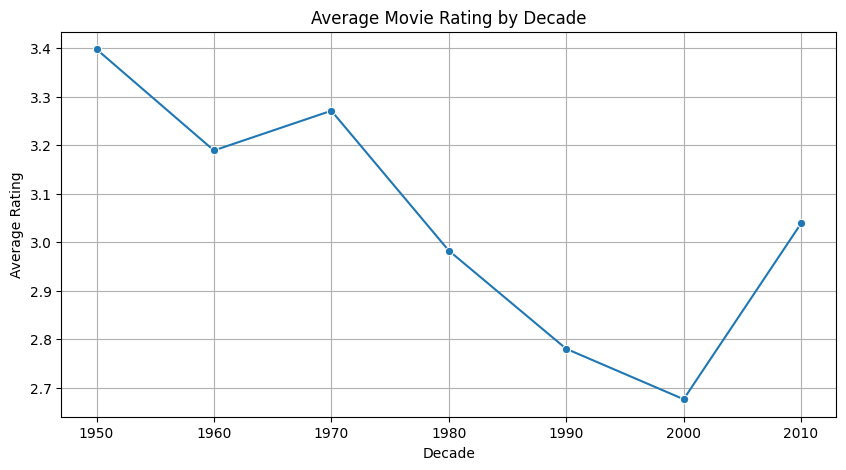

In [48]:
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)
df.dropna(subset=['release_year'], inplace=True)
df['decade'] = (df['release_year'] // 10 * 10).astype(int)

rating_by_decade = df.groupby('decade')['avg_rating'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=rating_by_decade, x='decade', y='avg_rating', marker='o')
plt.title('Average Movie Rating by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

### Q2: Which movies have the highest and lowest average ratings?

In [49]:
top_rated = df.sort_values(by='avg_rating', ascending=False)[['title', 'avg_rating']].head(10)
print("Top Rated Movies:\n", top_rated)

Top Rated Movies:
                                 title  avg_rating
219   Samay: When Time Strikes (2003)        5.00
730  Humpty Sharma Ki Dulhania (2014)        5.00
565           Shor in the City (2011)        5.00
278                   Hooligan (1998)        5.00
761                     Hichki (2018)        4.75
292          Death of a Doctor (1991)        4.75
782         Ramaiya Vastavaiya (2013)        4.50
328                Naram Garam (1981)        4.50
243                     Jungle (2000)        4.50
303                     Sparsh (1980)        4.50


In [50]:
lowest_rated = df.sort_values(by='avg_rating')[['title', 'avg_rating']].head(10)
print("\nLowest Rated Movies:\n", lowest_rated)


Lowest Rated Movies:
                             title  avg_rating
706                 Armaan (2003)         0.5
471  Chura Liyaa Hai Tumne (2003)         0.5
374                   Bhai (1997)         0.5
476                   Hawa (2003)         0.5
571                  Ghost (2012)         0.5
657           Naughty @ 40 (2011)         0.5
459  Maine Dil Tujhko Diya (2002)         0.5
520                      D (2005)         0.5
526            Bhoot Unkle (2006)         0.5
774                 Race 3 (2018)         0.5


### Q3: What are the most common genome tags associated with highly rated movies?

In [51]:
df['top_relevant_tags'] = df['top_relevant_tags'].fillna('').astype(str)
df_exploded = df.assign(tag=df['top_relevant_tags'].str.split(',')).explode('tag')
df_exploded['tag'] = df_exploded['tag'].str.strip().str.lower()
df_exploded = df_exploded[~df_exploded['tag'].isin(['', 'unknown'])]
tag_ratings = df_exploded.groupby('tag')['avg_rating'].mean().sort_values(ascending=False).head(15)

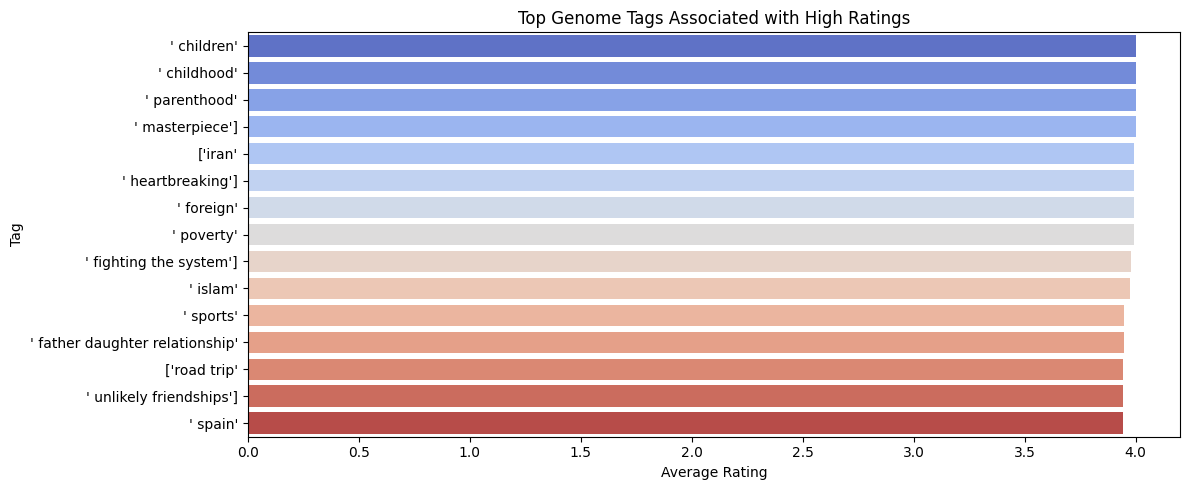

In [52]:
plt.figure(figsize=(12, 5))
sns.barplot(x=tag_ratings.values, y=tag_ratings.index, palette='coolwarm')
plt.title('Top Genome Tags Associated with High Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

### Q4: Which tags appear both in user tags and genome tags most frequently?

In [53]:
df['user_tags'] = df['user_tags'].fillna('').apply(lambda x: [tag.strip().lower() for tag in str(x).split(',')])
df['top_relevant_tags'] = df['top_relevant_tags'].fillna('').apply(lambda x: [tag.strip().lower() for tag in str(x).split(',')])

In [54]:
def get_overlap_tags(df):
    overlap_counts = Counter()

    for _, row in df.iterrows():
        user_tags = row['user_tags'] if isinstance(row['user_tags'], list) else []
        genome_tags = row['top_relevant_tags'] if isinstance(row['top_relevant_tags'], list) else []
        common_tags = set(user_tags).intersection(set(genome_tags))
        overlap_counts.update(common_tags)

    top_common_tags = overlap_counts.most_common(15)
    return pd.DataFrame(top_common_tags, columns=["tag", "overlap_frequency"])

top_overlap_tags = get_overlap_tags(df)
print(top_overlap_tags)

                     tag  overlap_frequency
0            ['unknown']                276
1           ' bollywood'                 11
2               ' india'                  8
3           ['bollywood'                  5
4              ' action'                  3
5                ' love'                  2
6             ' dancing'                  2
7             ' musical'                  2
8               ' drama'                  2
9            ' religion'                  2
10            ' poverty'                  1
11       ' prostitution'                  1
12            ' lesbian'                  1
13  ' social commentary'                  1
14              ' story'                  1


### Q5: Which tags are linked to movies with the most varied (mixed) ratings?

In [55]:
tag_rating_map = defaultdict(list)

for _, row in df.iterrows():
    if isinstance(row['user_tags'], list):
        tags = [tag.strip().lower() for tag in row['user_tags']]
    else:
        tags = str(row['user_tags']).split(',') if pd.notna(row['user_tags']) else []
        tags = [tag.strip().lower() for tag in tags]

    for tag in tags:
        tag_rating_map[tag].append(row['avg_rating'])

tag_variances = [(tag, np.std(ratings)) for tag, ratings in tag_rating_map.items() if len(ratings) >= 5]

tag_variance_df = pd.DataFrame(tag_variances, columns=['tag', 'rating_std']).sort_values(by='rating_std', ascending=False)

print(tag_variance_df.head(10))

                   tag  rating_std
49           ' sport']    1.074614
0          ['unknown']    1.020598
56  ['woman director']    0.922958
21           ' murder'    0.869090
35       ' friendship'    0.842951
54      ' boman irani'    0.809522
15           ' indian'    0.771407
4             ' india'    0.759827
32           ' family'    0.746605
40       ['bollywood']    0.740331


### Q6: Do top-rated movies tend to have more user tags than low-rated movies?

In [56]:
df['user_tag_count'] = df['user_tags'].apply(
    lambda x: len(x) if isinstance(x, list)
    else len(str(x).split(',')) if pd.notna(x)
    else 0
)
high_threshold = df['avg_rating'].quantile(0.9)
low_threshold = df['avg_rating'].quantile(0.1)

In [57]:
high_tag_avg = df[df['avg_rating'] >= high_threshold]['user_tag_count'].mean()

In [58]:
print(f"Average user tags for top 10% rated movies: {high_tag_avg:.2f}")

Average user tags for top 10% rated movies: 5.19


In [59]:
low_tag_avg = df[df['avg_rating'] <= low_threshold]['user_tag_count'].mean()

In [60]:
print(f"Average user tags for bottom 10% rated movies: {low_tag_avg:.2f}")

Average user tags for bottom 10% rated movies: 1.62


### Q7: How does the number of user tags vary across different rating groups?

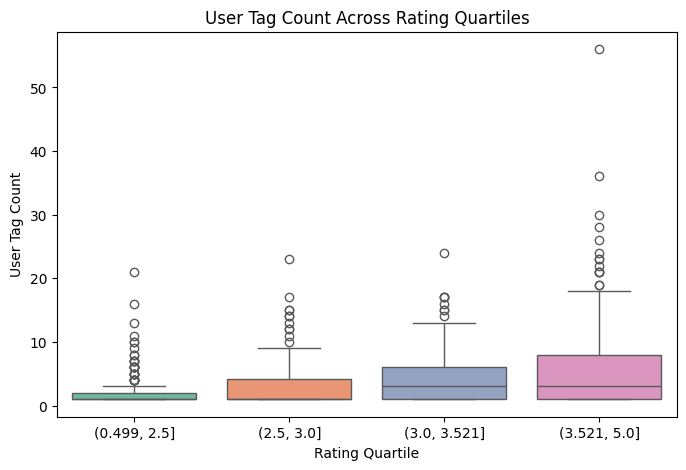

In [61]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x=pd.qcut(df['avg_rating'], q=4), y='user_tag_count', palette='Set2')
plt.title("User Tag Count Across Rating Quartiles")
plt.xlabel("Rating Quartile")
plt.ylabel("User Tag Count")
plt.show()

### Q8: Is there a relationship between the number of tags and a movie's average rating?

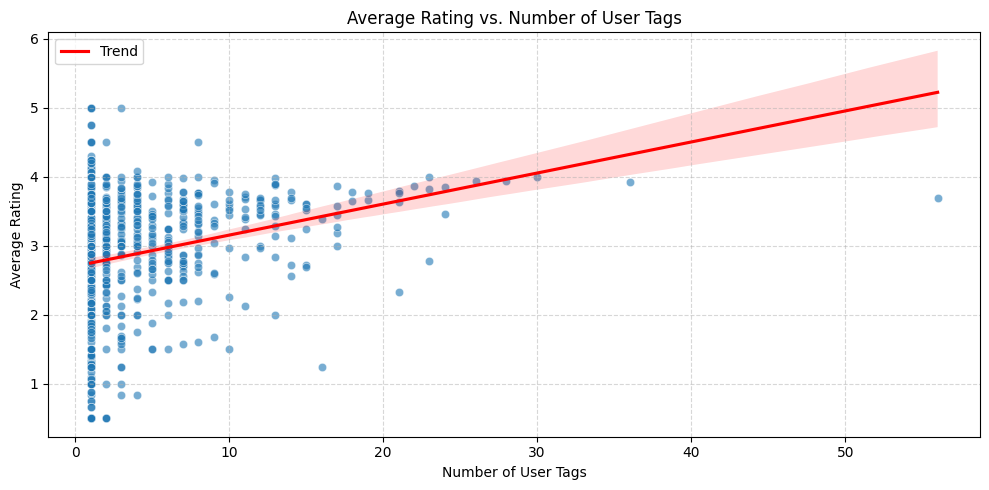

In [62]:
df['user_tag_count'] = df['user_tags'].apply(len) if isinstance(df['user_tags'].iloc[0], list) else \
    df['user_tags'].fillna('').apply(lambda x: len(str(x).split(',')))

plt.figure(figsize=(10, 5))
sns.scatterplot(x='user_tag_count', y='avg_rating', data=df, alpha=0.6)
sns.regplot(x='user_tag_count', y='avg_rating', data=df, scatter=False, color='red', label='Trend')
plt.title('Average Rating vs. Number of User Tags')
plt.xlabel('Number of User Tags')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Q9: What are the most commonly used tags across all movies?

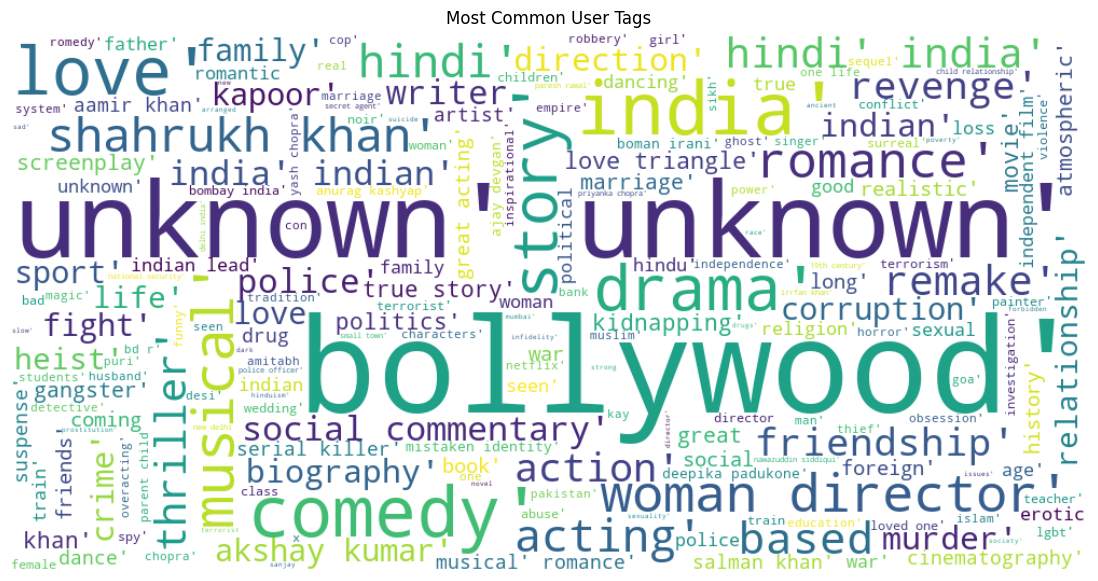

In [63]:
all_tags = df['user_tags'].explode().dropna().astype(str).str.lower().str.strip()
tag_text = ' '.join(all_tags)

wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(tag_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common User Tags')
plt.show()